# Cálculo de la frecuencia cardiaca a partir de los datos crudos del sensor

Este notebook es una conclusión de todas las pruebas válidas y fallidas que he probado para estimar la frecuencia cardiaca.

En resumen, este bloque de código automatiza el análisis de múltiples señales IR registradas por el pulsioxímetro. Para cada archivo CSV:

## Estimación de la frecuencia cardíaca a partir de señales PPG

Este notebook implementa un sistema automatizado para procesar señales PPG (fotopletismográficas) recogidas desde un pulsioxímetro. El objetivo principal es estimar la frecuencia cardíaca (HR, Heart Rate) a partir de archivos de datos crudos almacenados en formato CSV.

1. **Carga y preprocesado de datos**  
   - Se cargan automáticamente todos los archivos `.csv` de una carpeta especificada.  
   - Se extrae la señal infrarroja (IR) y se elimina el segmento inicial de 5 segundos para evitar artefactos de contacto.

2. **Filtrado paso bajo**  
   - Se aplica un filtro digital Butterworth (≤3 Hz) para eliminar ruido de alta frecuencia y mantener solo el contenido pulsátil.

3. **Detección de picos (dominio temporal)**  
   - Se detectan los máximos locales en la señal filtrada que corresponden a los latidos.  
   - Se calcula la frecuencia cardíaca como el inverso del intervalo medio entre picos, expresado en BPM (latidos por minuto).

4. **Análisis espectral mediante FFT**  
   - Se calcula la Transformada Rápida de Fourier (FFT) de la señal IR filtrada.  
   - Se identifica el pico espectral dominante en el rango [0.5, 3] Hz, lo que permite estimar la HR en el dominio de la frecuencia.

5. **Visualización de resultados**  
   - Se generan dos gráficas por archivo: una con la señal temporal y los latidos detectados, y otra con el espectro de frecuencia (FFT).

Este enfoque permite evaluar tanto la calidad de la señal como la coherencia entre la estimación temporal (picos) y la estimación espectral (frecuencia dominante). Es especialmente útil para validar el funcionamiento de algoritmos en contextos clínicos o embebidos.



Primero voy a visualizar los datos para ver qué sobra de cada señal, en vez de hacer un recorte generalizado que puede generar errores y eliminar información.

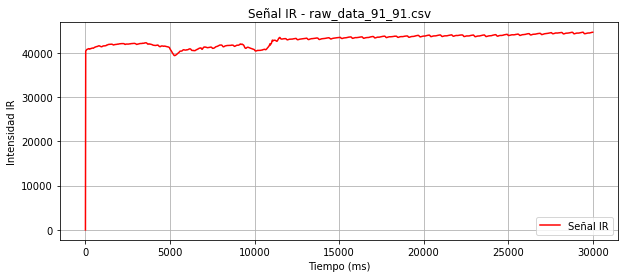

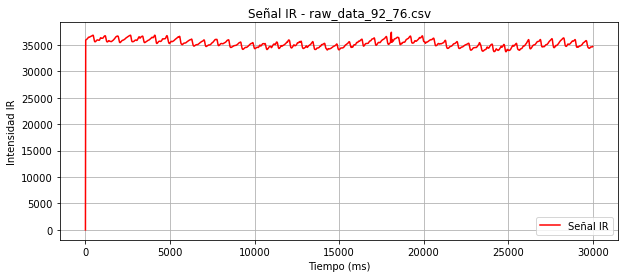

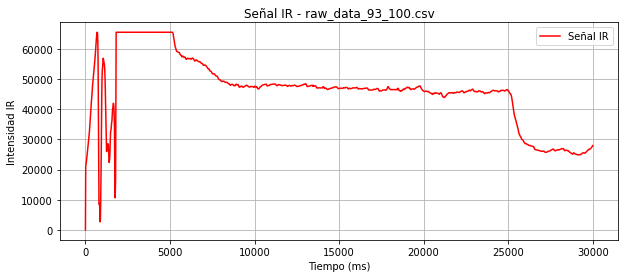

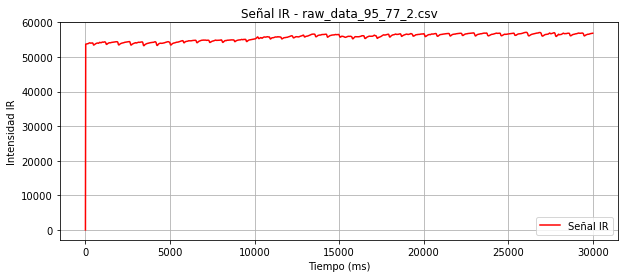

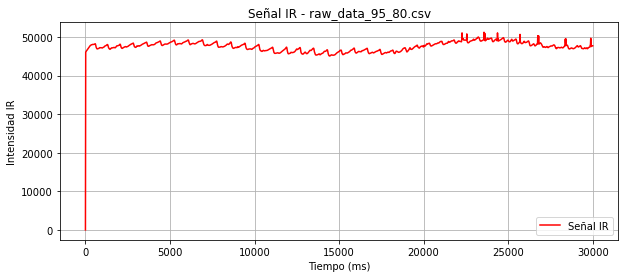

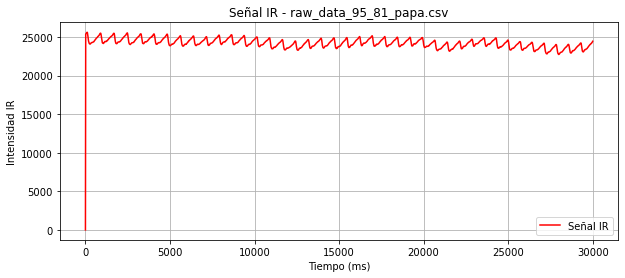

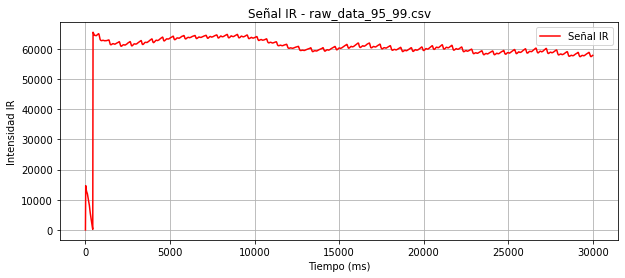

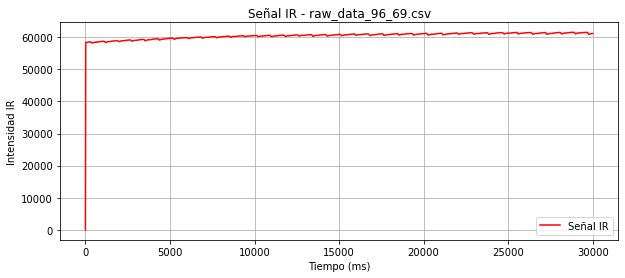

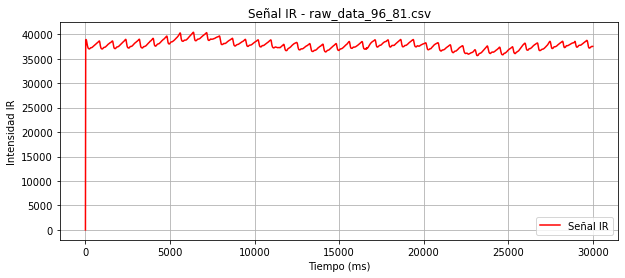

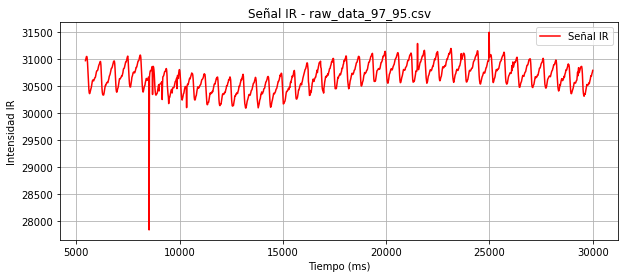

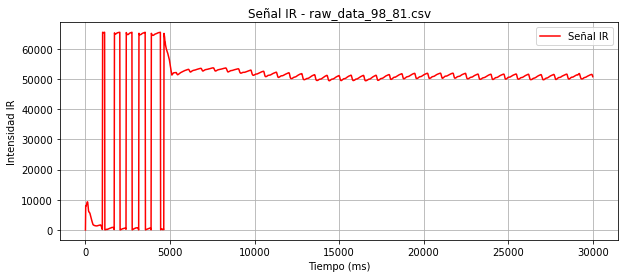

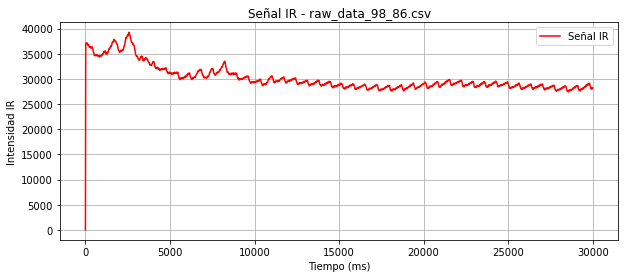

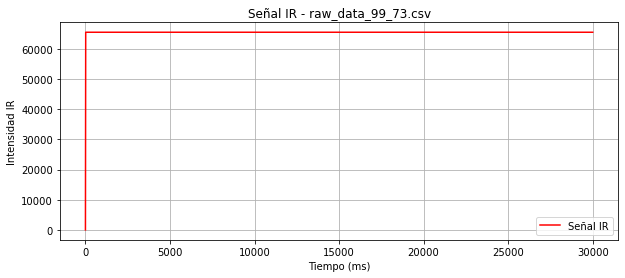

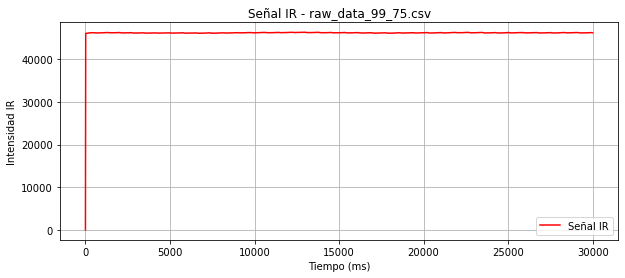

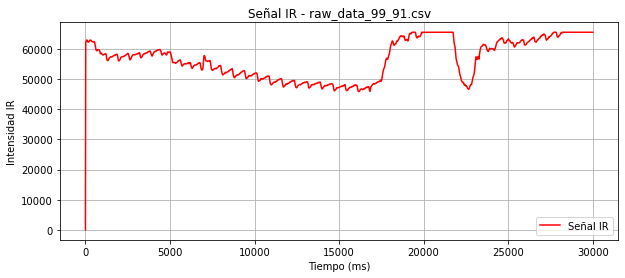

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

ruta_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2"

archivos = glob.glob(os.path.join(ruta_csv, "*.csv"))

# Iterar sobre cada archivo y graficar la señal IR
for archivo in archivos:
    # Cargar datos
    df = pd.read_csv(archivo)

    # Verificar que la columna "IR" existe
    if "IR" not in df.columns:
        print(f"Advertencia: No se encontró la columna 'IR' en {archivo}")
        continue

    # Graficar la señal IR
    plt.figure(figsize=(10, 4))
    plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="red")
    plt.xlabel("Tiempo (ms)")
    plt.ylabel("Intensidad IR")
    plt.title(f"Señal IR - {os.path.basename(archivo)}")
    plt.legend()
    plt.grid()
    plt.show()


## Frecuencia estimada de 91 BPM

Frecuencia cardíaca estimada: 90.81 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 91.50 BPM


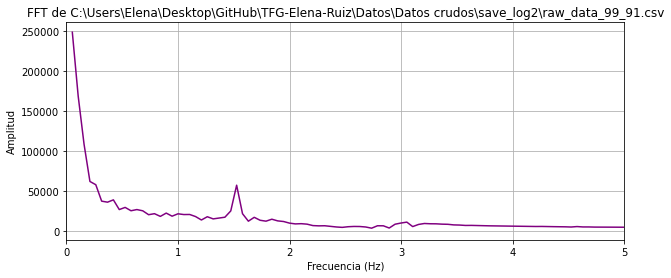

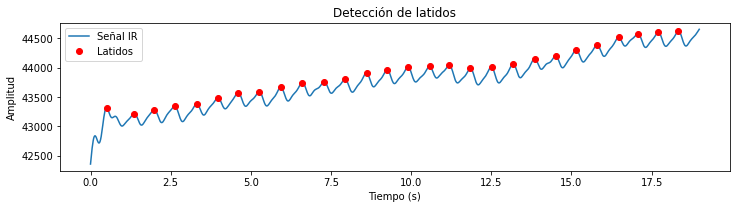

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Eliminar los primeros 11 segundos
    indice_inicio = np.searchsorted(tiempo, 11)
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:]
    
    return tiempo, señal_ir

def filtrar_senal(señal, fs=60, cutoff=3, order=4):
    """Aplica un filtro pasa-bajos para reducir ruido"""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    señal_filtrada = filtfilt(b, a, señal)
    return señal_filtrada


def detectar_picos(señal, tiempo, umbral=0.5, distancia=0.5):
    """Detecta picos en la señal filtrada que correspondan a latidos."""
    peaks, _ = find_peaks(señal, height=umbral, distance=distancia*(len(tiempo)/max(tiempo)))
    tiempos_picos = tiempo[peaks]
    return tiempos_picos

def calcular_frecuencia_cardiaca(tiempos_picos):
    """Calcula la frecuencia cardíaca a partir del tiempo entre picos."""
    if len(tiempos_picos) < 2:
        return None  # No hay suficientes latidos detectados
    diferencias = np.diff(tiempos_picos)
    frecuencia = 60 / np.mean(diferencias)
    return frecuencia

def visualizar_fft(tiempo, señal, fs=60, archivo=""):
    """Calcula y grafica la FFT de la señal filtrada."""
    n = len(señal)
    fft_y = np.fft.fft(señal)
    freqs = np.fft.fftfreq(n, d=1/fs)

    positivos = freqs > 0
    freqs = freqs[positivos]
    fft_y = np.abs(fft_y[positivos])

    # Buscar pico entre 0.5 y 3 Hz
    rango = (freqs >= 0.5) & (freqs <= 3)
    if np.any(rango):
        frecuencia_dominante = freqs[rango][np.argmax(fft_y[rango])]
        frecuencia_bpm = frecuencia_dominante * 60
        print(f"[FFT] Frecuencia cardíaca estimada para {archivo}: {frecuencia_bpm:.2f} BPM")
    else:
        print(f"[FFT] No se detectó frecuencia dominante en {archivo}.")

    # Graficar FFT
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, fft_y, color='purple')
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Amplitud")
    plt.title(f"FFT de {archivo}")
    plt.xlim(0, 5)
    plt.grid(True)
    plt.show()


def visualizar_senal(tiempo, señal, tiempos_picos):
    """Grafica la señal con los picos detectados."""
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(tiempo, señal, label="Señal IR")
    plt.plot(tiempos_picos, señal[np.searchsorted(tiempo, tiempos_picos)], 'ro', label="Latidos")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.title("Detección de latidos")
    plt.show()

# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_91_91.csv"  # Modifica según corresponda
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia estimada de 76 BPM

Frecuencia cardíaca estimada: 84.21 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 85.71 BPM


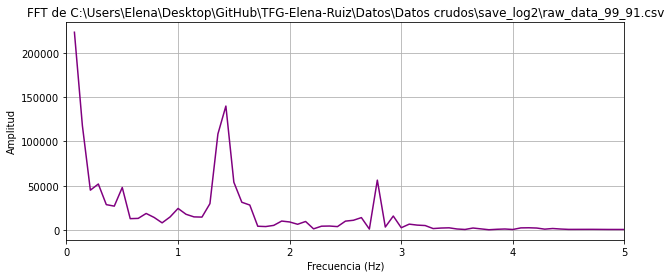

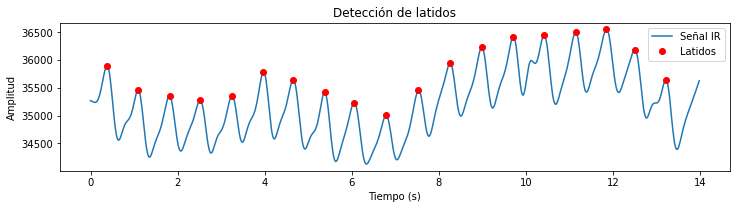

In [20]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 8)  # Primer dato después de 8s
    indice_fin = np.searchsorted(tiempo, tiempo[-1] - 8)  # Último dato antes de 5s del final

    # Recortar los datos
    tiempo = tiempo[indice_inicio:indice_fin] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:indice_fin]
    
    return tiempo, señal_ir
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_92_76.csv"  # Modifica según corresponda
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia estimada de 100 BPM

Frecuencia cardíaca estimada: 76.05 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 98.57 BPM


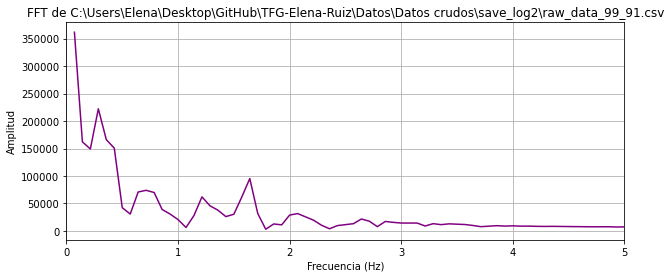

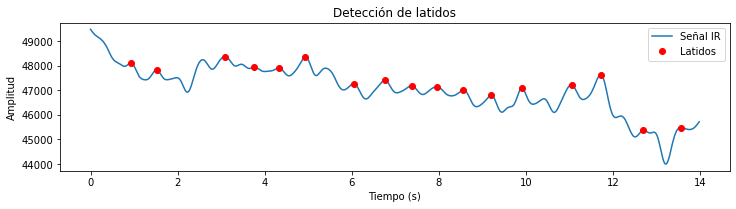

In [21]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 8)  # Primer dato después de 8s
    indice_fin = np.searchsorted(tiempo, tiempo[-1] - 8)  # Último dato antes de 5s del final

    # Recortar los datos
    tiempo = tiempo[indice_inicio:indice_fin] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:indice_fin]
    
    return tiempo, señal_ir
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_93_100.csv"  # Modifica según corresponda
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia esperada de 77 BPM

Frecuencia cardíaca estimada: 80.65 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 79.19 BPM


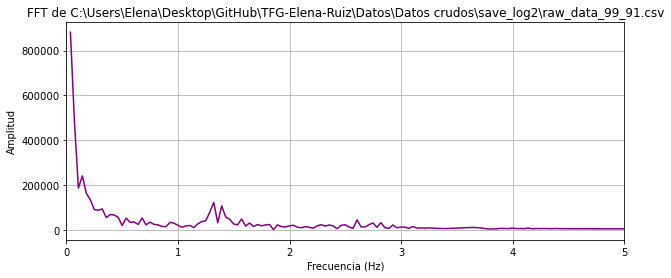

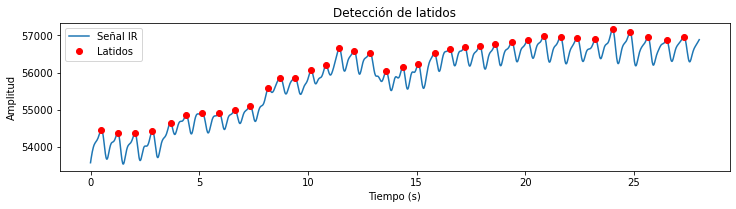

In [22]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 2)  # Primer dato después de 8s
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:]
    
    return tiempo, señal_ir
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_95_77_2.csv"  
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia cardiaca esperada de 80 BPM

Frecuencia cardíaca estimada: 77.31 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 72.77 BPM


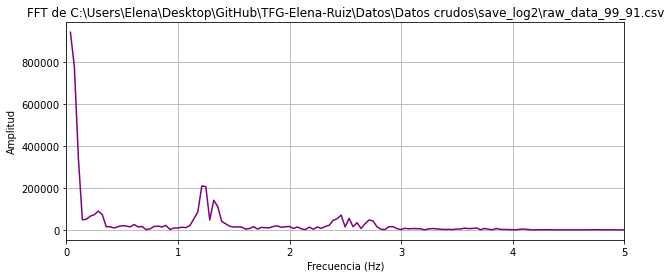

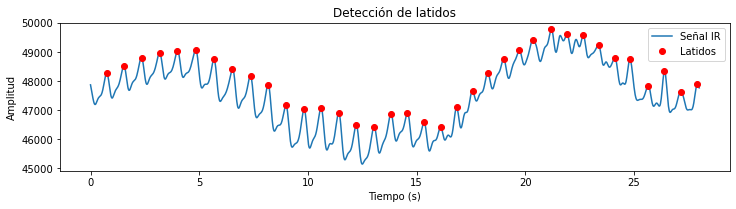

In [23]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 2)  # Primer dato después de 8s
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:]
    
    return tiempo, señal_ir
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_95_80.csv"  
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia cardiaca esperada de 81 BPM

Frecuencia cardíaca estimada: 80.55 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 79.19 BPM


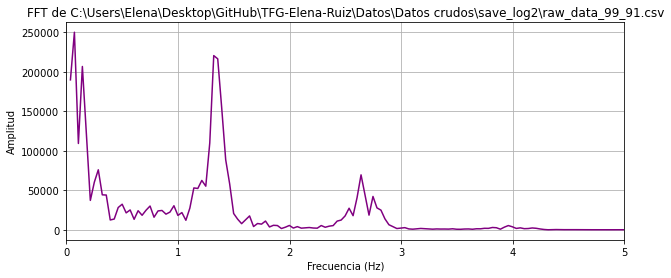

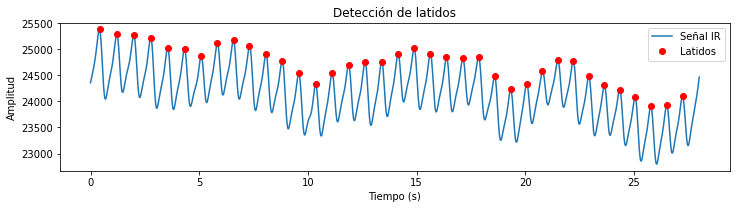

In [24]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 2)  # Primer dato después de 8s
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:]
    
    return tiempo, señal_ir
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_95_81_papa.csv"  
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia cardiaca esperada de 99 BPM

Frecuencia cardíaca estimada: 95.09 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 98.45 BPM


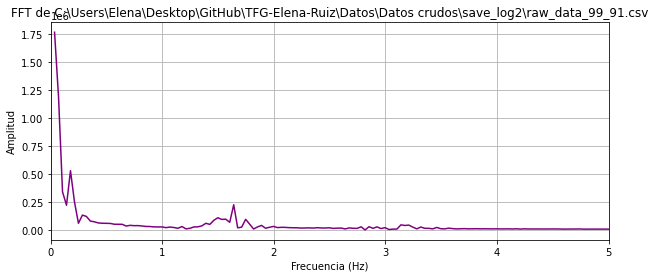

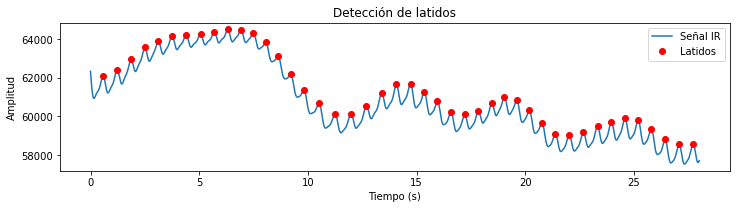

In [25]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 2)  # Primer dato después de 8s
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:]
    
    return tiempo, señal_ir
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_95_99.csv"  
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia cardiaca estimada de 69 BPM

Frecuencia cardíaca estimada: 71.11 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 68.49 BPM


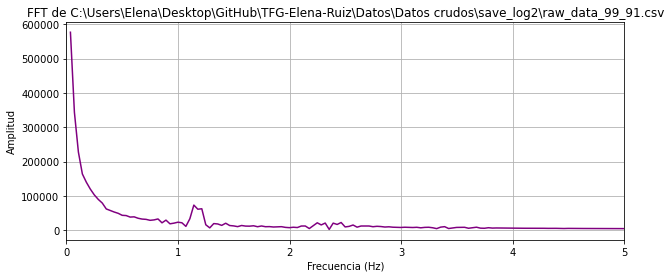

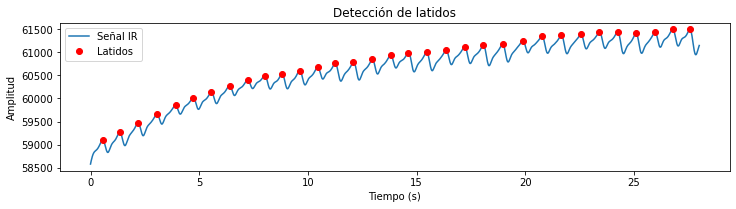

In [26]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 2)  # Primer dato después de 8s
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:]
    
    return tiempo, señal_ir
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_96_69.csv"  
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia cardiaca de 81 BPM

Frecuencia cardíaca estimada: 80.46 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 79.94 BPM


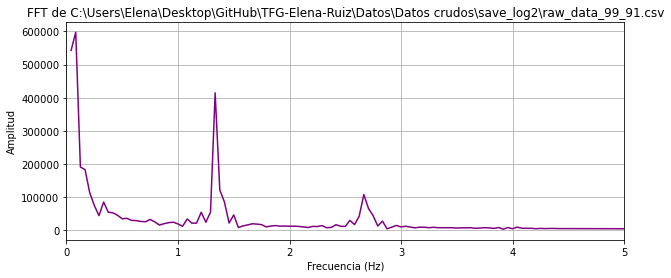

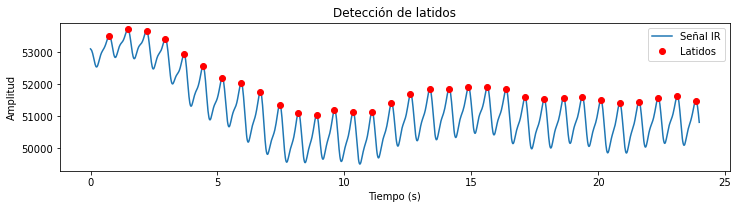

In [27]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 6)  # Primer dato después de 8s
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:]
    
    return tiempo, señal_ir
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_98_81.csv"  
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia cardiaca esperada de 75 BPM

Frecuencia cardíaca estimada: 75.01 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 74.91 BPM


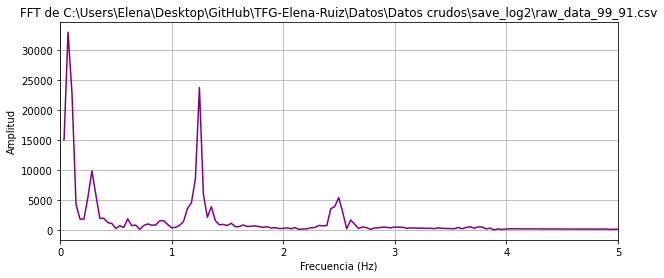

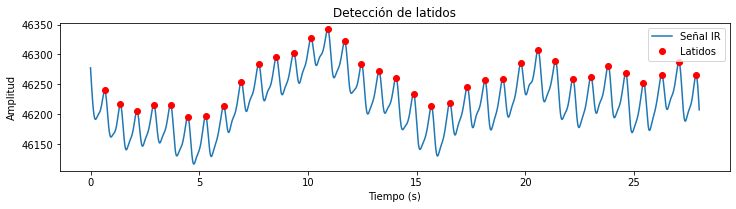

In [28]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 2)  # Primer dato después de 8s
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:]
    
    return tiempo, señal_ir
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_99_75.csv"  
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia cardiaca esperada de 91 BPM

Frecuencia cardíaca estimada: 84.57 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 83.91 BPM


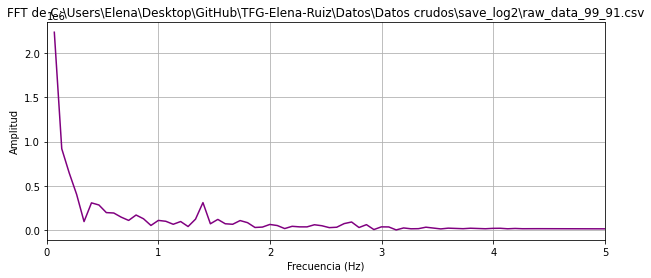

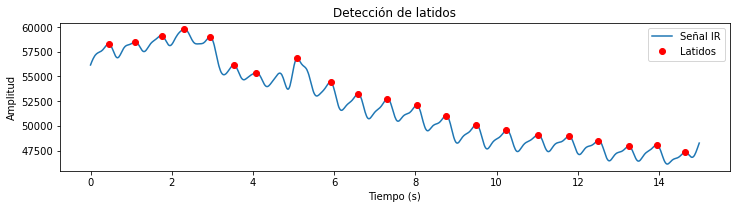

In [29]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
  # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 2)  # Primer dato después de 8s
    indice_fin = np.searchsorted(tiempo, tiempo[-1] - 13)  # Último dato antes de 5s del final

    # Recortar los datos
    tiempo = tiempo[indice_inicio:indice_fin] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:indice_fin]
    
    return tiempo, señal_ir
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_99_91.csv"  
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia cardiaca esperada de 86 BPM

Frecuencia cardíaca estimada: 86.12 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 86.34 BPM


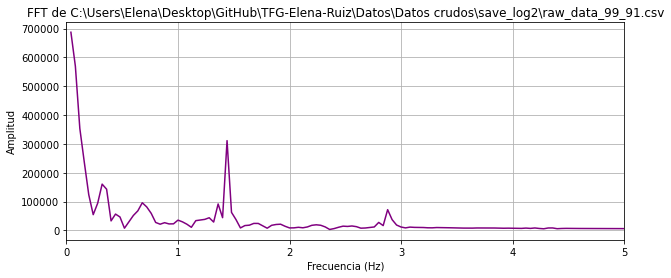

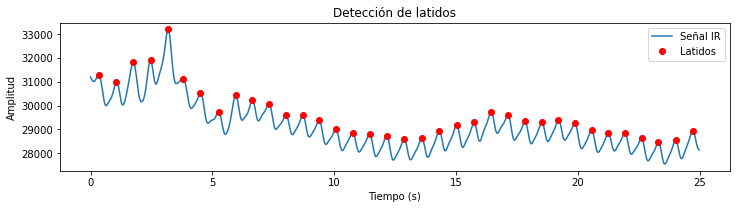

In [30]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
  # Encontrar los índices para recortar la señal
    indice_inicio = np.searchsorted(tiempo, 5)  # Primer dato después de 8s
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:]
    
    return tiempo, señal_ir
    
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_98_86.csv"  
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


## Frecuencia cardiaca estimada de 95 BPM

Frecuencia cardíaca estimada: 95.34 BPM
[FFT] Frecuencia cardíaca estimada para C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_99_91.csv: 95.19 BPM


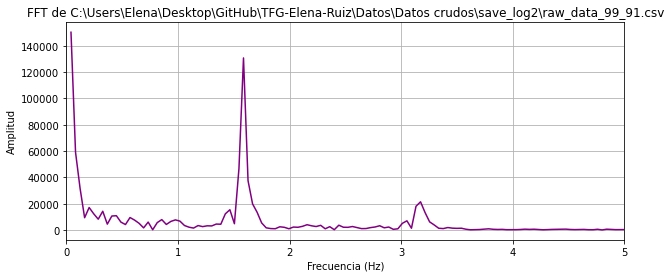

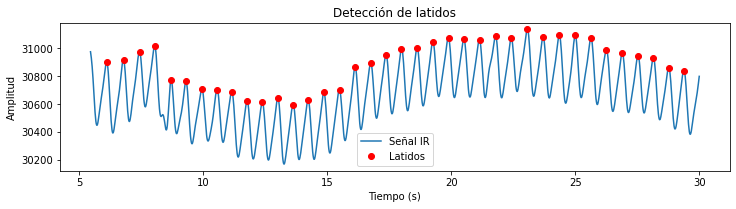

In [31]:
def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
  # Encontrar los índices para recortar la señal
    # no hace falta recorte
    
    return tiempo, señal_ir
    
# Uso del código
def main():
    ruta_csv = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_97_95.csv"  
    tiempo, señal_ir = cargar_datos(ruta_csv)
    señal_filtrada = filtrar_senal(señal_ir)
    tiempos_picos = detectar_picos(señal_filtrada, tiempo)
    frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
    
    if frecuencia_cardiaca:
        print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")
    else:
        print("No se detectaron suficientes latidos.")
    visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
    visualizar_senal(tiempo, señal_filtrada, tiempos_picos)

if __name__ == "__main__":
    main()


Procesando: raw_data_91_91.csv
Frecuencia cardíaca estimada para raw_data_91_91.csv: 82.81 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_91_91.csv: 35.98 BPM


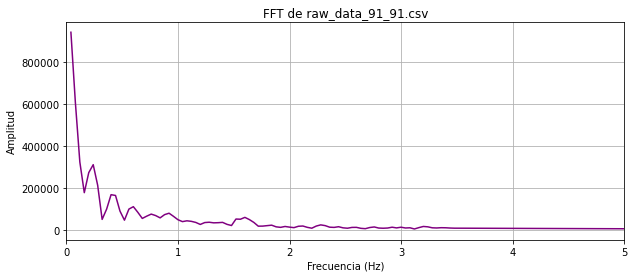

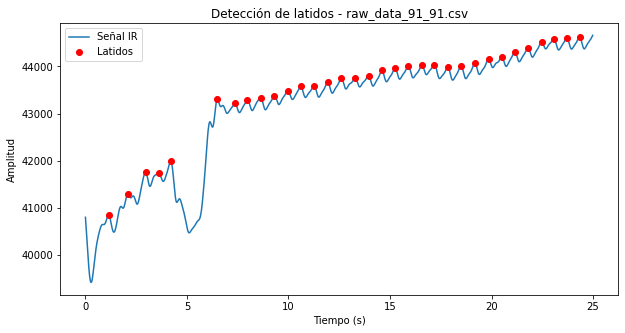

Procesando: raw_data_92_76.csv
Frecuencia cardíaca estimada para raw_data_92_76.csv: 84.76 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_92_76.csv: 83.94 BPM


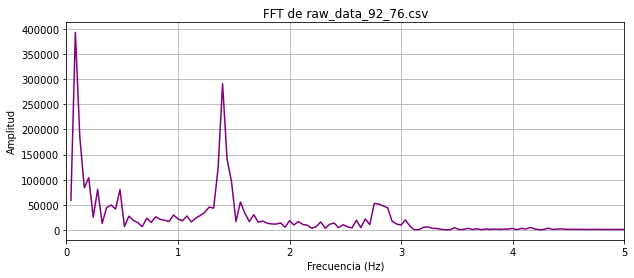

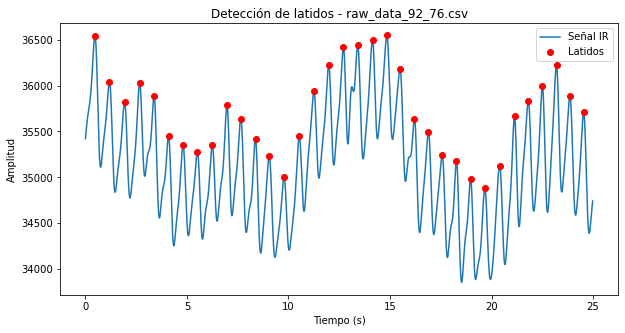

Procesando: raw_data_93_100.csv
Frecuencia cardíaca estimada para raw_data_93_100.csv: 63.02 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_93_100.csv: 33.58 BPM


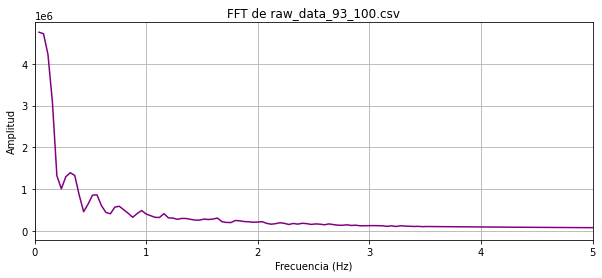

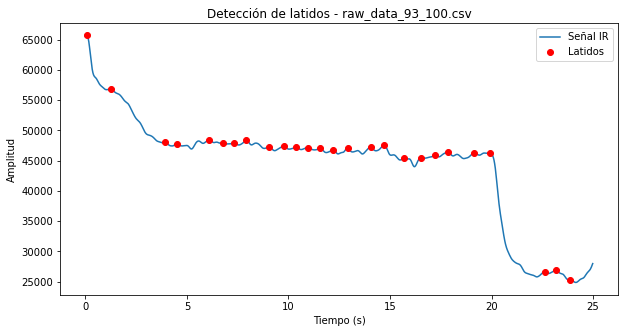

Procesando: raw_data_95_77_2.csv
Frecuencia cardíaca estimada para raw_data_95_77_2.csv: 81.35 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_95_77_2.csv: 83.94 BPM


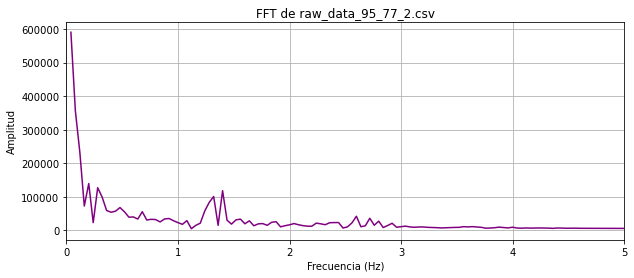

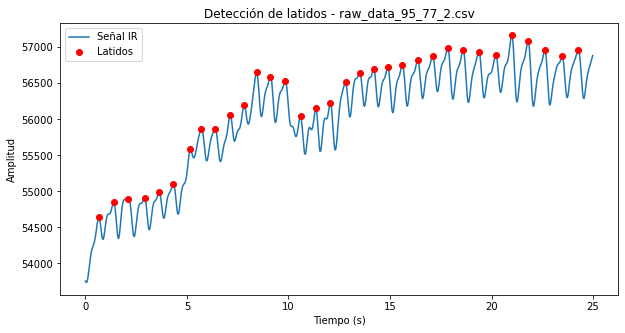

Procesando: raw_data_95_80.csv
Frecuencia cardíaca estimada para raw_data_95_80.csv: 77.63 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_95_80.csv: 71.95 BPM


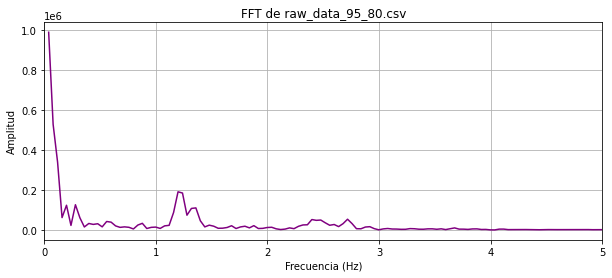

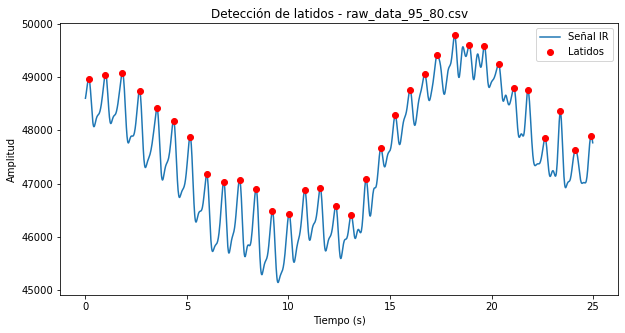

Procesando: raw_data_95_81_papa.csv
Frecuencia cardíaca estimada para raw_data_95_81_papa.csv: 81.07 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_95_81_papa.csv: 81.55 BPM


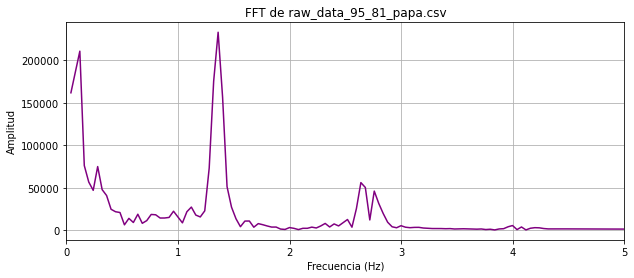

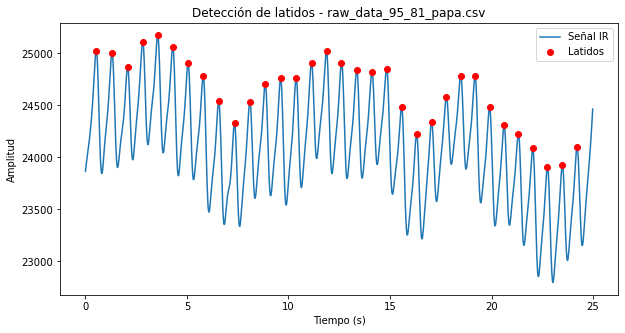

Procesando: raw_data_95_99.csv
Frecuencia cardíaca estimada para raw_data_95_99.csv: 95.12 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_95_99.csv: 98.33 BPM


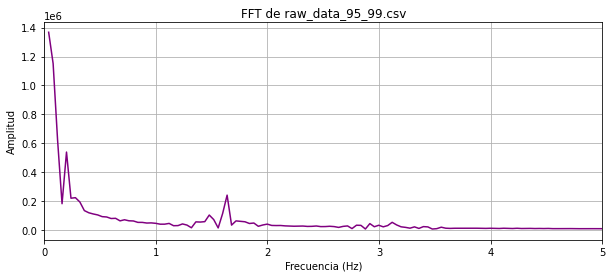

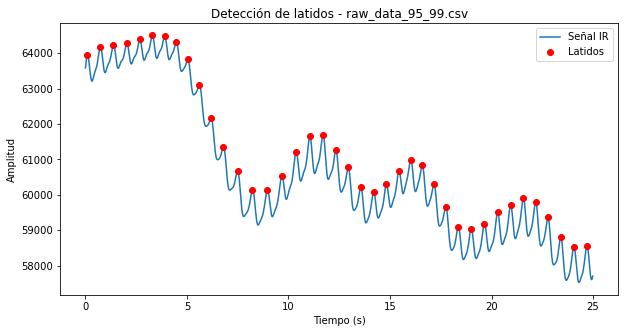

Procesando: raw_data_96_69.csv
Frecuencia cardíaca estimada para raw_data_96_69.csv: 71.07 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_96_69.csv: 69.55 BPM


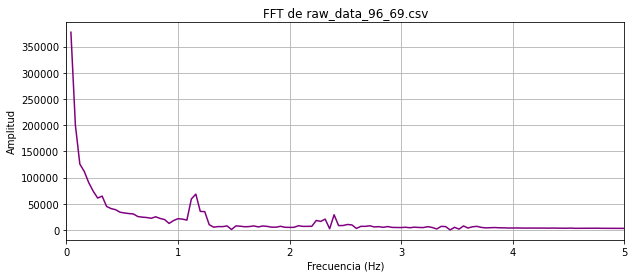

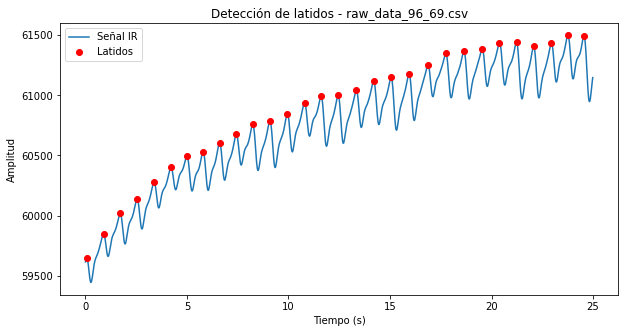

Procesando: raw_data_96_81.csv
Frecuencia cardíaca estimada para raw_data_96_81.csv: 79.89 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_96_81.csv: 79.15 BPM


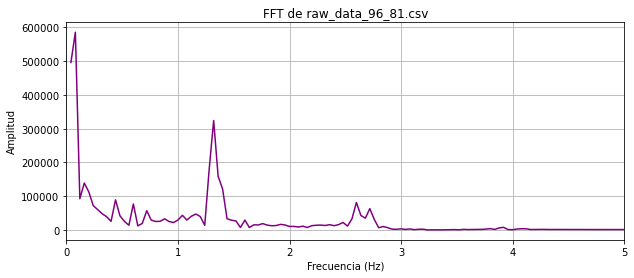

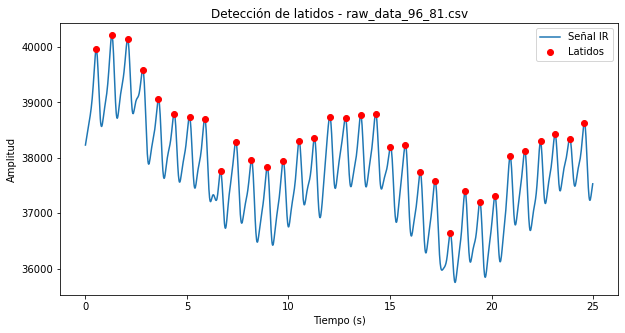

Procesando: raw_data_97_95.csv
Frecuencia cardíaca estimada para raw_data_97_95.csv: 95.34 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_97_95.csv: 95.19 BPM


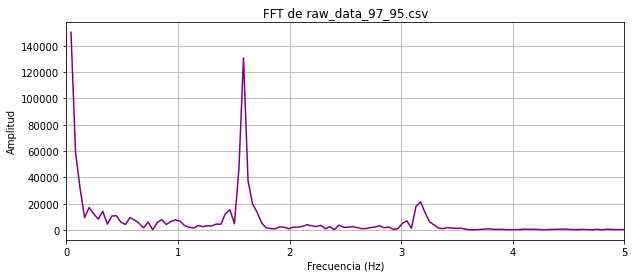

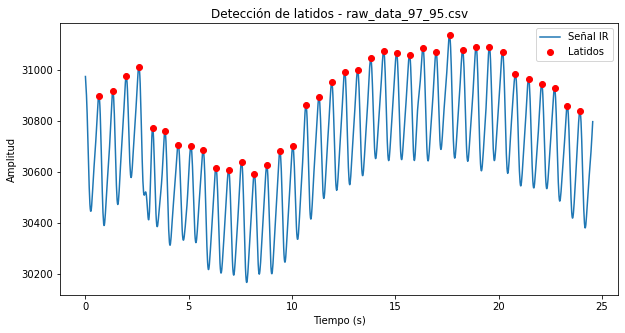

Procesando: raw_data_98_81.csv
Frecuencia cardíaca estimada para raw_data_98_81.csv: 80.65 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_98_81.csv: 79.15 BPM


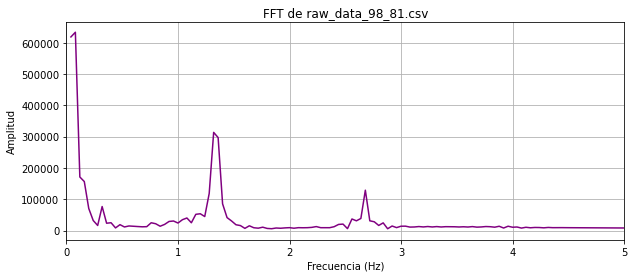

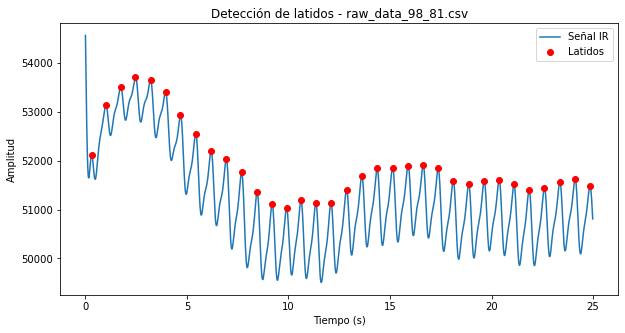

Procesando: raw_data_98_86.csv
Frecuencia cardíaca estimada para raw_data_98_86.csv: 86.12 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_98_86.csv: 86.34 BPM


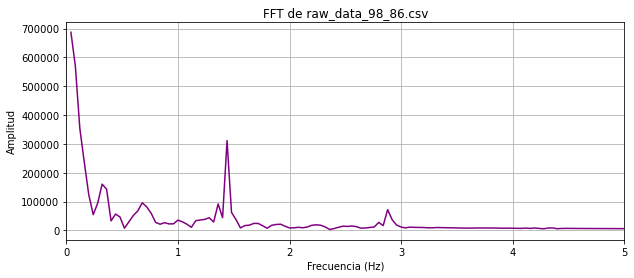

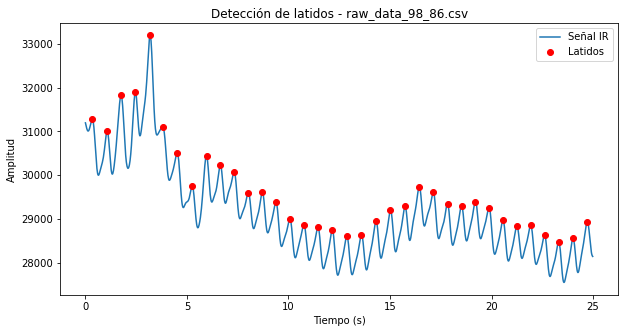

Procesando: raw_data_99_73.csv
Frecuencia cardíaca estimada para raw_data_99_73.csv: 67.97 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_99_73.csv: 45.57 BPM


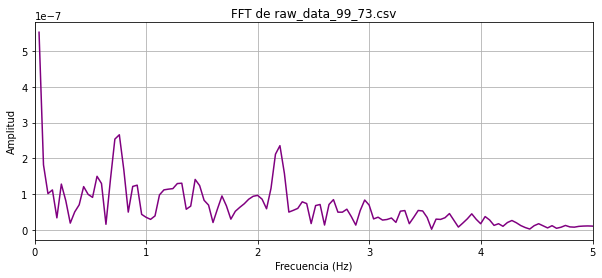

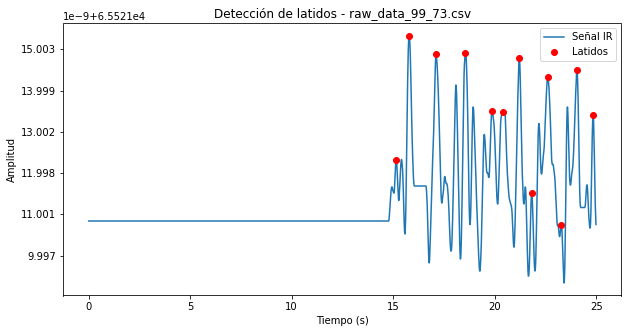

Procesando: raw_data_99_75.csv
Frecuencia cardíaca estimada para raw_data_99_75.csv: 74.48 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_99_75.csv: 74.35 BPM


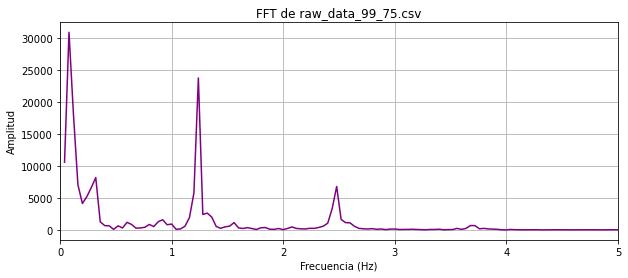

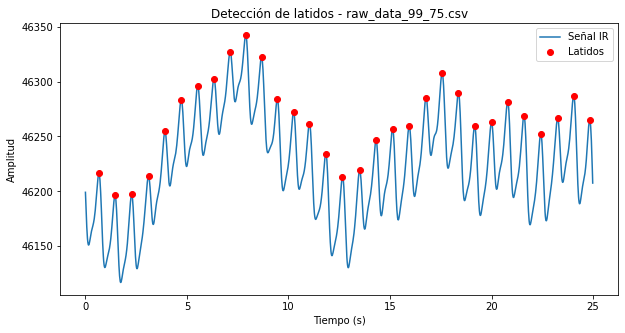

Procesando: raw_data_99_91.csv
Frecuencia cardíaca estimada para raw_data_99_91.csv: 74.53 BPM
[FFT] Frecuencia cardíaca estimada para raw_data_99_91.csv: 35.98 BPM


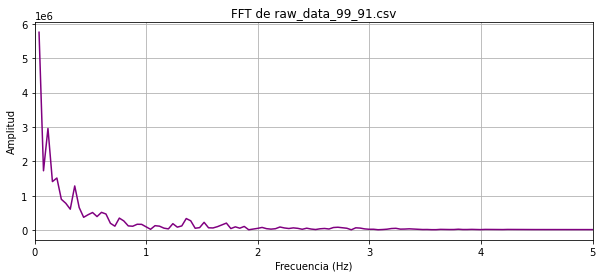

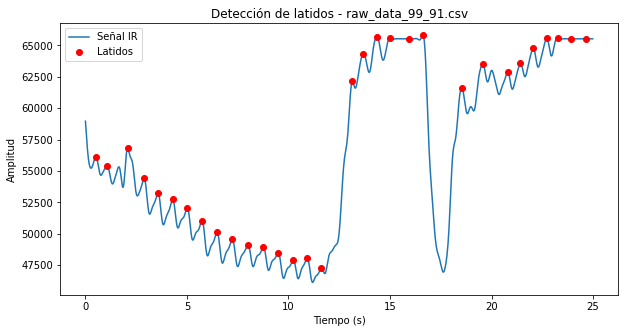

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks, butter, filtfilt

def cargar_datos(ruta_csv):
    """Carga los datos del CSV y devuelve el tiempo y la señal IR, eliminando los primeros 3 segundos."""
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos si está en ms
    señal_ir = df.iloc[:, 1].values
    
    # Eliminar los primeros 3 segundos
    indice_inicio = np.searchsorted(tiempo, 5)
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]  # Reajustar tiempo a partir de 0
    señal_ir = señal_ir[indice_inicio:]
    
    return tiempo, señal_ir

def filtrar_senal(señal, fs=60, cutoff=3, order=4):
    """Aplica un filtro pasa-bajos para reducir ruido."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    señal_filtrada = filtfilt(b, a, señal)
    return señal_filtrada

def detectar_picos(señal, tiempo, umbral=0.5, distancia=0.5):
    """Detecta picos en la señal filtrada que correspondan a latidos."""
    peaks, _ = find_peaks(señal, height=umbral, distance=distancia*(len(tiempo)/max(tiempo)))
    tiempos_picos = tiempo[peaks]
    return tiempos_picos

def calcular_frecuencia_cardiaca(tiempos_picos):
    """Calcula la frecuencia cardíaca a partir del tiempo entre picos."""
    if len(tiempos_picos) < 2:
        return None  # No hay suficientes latidos detectados
    diferencias = np.diff(tiempos_picos)
    frecuencia = 60 / np.mean(diferencias)
    return frecuencia

def visualizar_senal(tiempo, señal, tiempos_picos, titulo):
    """Grafica la señal con los picos detectados."""
    plt.figure(figsize=(10, 5))
    plt.plot(tiempo, señal, label="Señal IR")
    plt.plot(tiempos_picos, señal[np.searchsorted(tiempo, tiempos_picos)], 'ro', label="Latidos")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.title(titulo)
    plt.show()

def procesar_archivos(directorio):
    """Procesa todos los archivos CSV en la carpeta especificada."""
    for archivo in os.listdir(directorio):
        if archivo.endswith(".csv"):
            ruta_csv = os.path.join(directorio, archivo)
            print(f"Procesando: {archivo}")
            tiempo, señal_ir = cargar_datos(ruta_csv)
            señal_filtrada = filtrar_senal(señal_ir)
            tiempos_picos = detectar_picos(señal_filtrada, tiempo)
            frecuencia_cardiaca = calcular_frecuencia_cardiaca(tiempos_picos)
            
            if frecuencia_cardiaca:
                print(f"Frecuencia cardíaca estimada para {archivo}: {frecuencia_cardiaca:.2f} BPM")
            else:
                print(f"No se detectaron suficientes latidos en {archivo}.")
            visualizar_fft(tiempo, señal_filtrada, fs=60, archivo=archivo)
            visualizar_senal(tiempo, señal_filtrada, tiempos_picos, titulo=f"Detección de latidos - {archivo}")

def main():
    directorio = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2"  
    procesar_archivos(directorio)

if __name__ == "__main__":
    main()


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
import re

# --- Funciones base ---
def cargar_datos(ruta_csv):
    df = pd.read_csv(ruta_csv)
    tiempo = df.iloc[:, 0].values / 1000  # Convertir a segundos
    señal_ir = df.iloc[:, 1].values
    indice_inicio = np.searchsorted(tiempo, 5)
    tiempo = tiempo[indice_inicio:] - tiempo[indice_inicio]
    señal_ir = señal_ir[indice_inicio:]
    return tiempo, señal_ir

def filtrar_senal(señal, fs=60, cutoff=3, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, señal)

def detectar_picos(señal, tiempo, umbral=0.5, distancia=0.5):
    peaks, _ = find_peaks(señal, height=umbral, distance=distancia * (len(tiempo)/max(tiempo)))
    return tiempo[peaks]

def calcular_frecuencia_cardiaca(tiempos_picos):
    if len(tiempos_picos) < 2:
        return None
    diferencias = np.diff(tiempos_picos)
    return 60 / np.mean(diferencias)

# --- Procesamiento por lotes ---
directorio = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"
resultados = []

for archivo in os.listdir(directorio):
    if archivo.endswith(".csv"):
        ruta_csv = os.path.join(directorio, archivo)

        try:
            tiempo, señal_ir = cargar_datos(ruta_csv)
            señal_filtrada = filtrar_senal(señal_ir)
            tiempos_picos = detectar_picos(señal_filtrada, tiempo)
            fc_estimada = calcular_frecuencia_cardiaca(tiempos_picos)
        except Exception as e:
            print(f" Error procesando {archivo}: {e}")
            continue

        match = re.match(r".*_(\d+)_(\d+)", archivo)
        fc_esperada = int(match.group(2)) if match else None

        resultados.append({
            "Archivo": archivo,
            "FC esperada (bpm)": fc_esperada,
            "FC estimada (bpm)": round(fc_estimada, 2) if fc_estimada else "Error"
        })

# --- Crear tabla final ---
tabla = pd.DataFrame(resultados)
print(tabla)

# --- Guardar CSV ---
csv_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\\resultados\resultados_resultados_procesamiento.csv"
tabla.to_csv(csv_path, index=False)

# --- Guardar como imagen ---
fig, ax = plt.subplots(figsize=(11, len(tabla) * 0.5 + 1))
ax.axis('off')
tabla_img = ax.table(cellText=tabla.values,
                     colLabels=tabla.columns,
                     cellLoc='center',
                     loc='center')
tabla_img.auto_set_font_size(False)
tabla_img.set_fontsize(10)
tabla_img.scale(1, 1.5)

png_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados\resultados_procesamiento.png"
plt.savefig(png_path, bbox_inches='tight', dpi=300)
plt.close()


                    Archivo  FC esperada (bpm)  FC estimada (bpm)
0        raw_data_91_91.csv                 91              91.91
1        raw_data_92_76.csv                 76              83.50
2       raw_data_93_100.csv                100              76.34
3      raw_data_95_77_2.csv                  2              81.35
4        raw_data_95_80.csv                 80              76.18
5   raw_data_95_81_papa.csv                 81              81.07
6        raw_data_95_99.csv                 99              95.12
7       raw_data_96_106.csv                106              66.77
8        raw_data_96_69.csv                 69              71.07
9       raw_data_97_119.csv                119              73.87
10       raw_data_97_95.csv                 95              95.25
11       raw_data_98_81.csv                 81              80.65
12       raw_data_98_86.csv                 86              85.97
13       raw_data_98_91.csv                 91              99.59
14       r